<a href="https://colab.research.google.com/github/irasin/pytroch_test/blob/master/181217.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install torch torchvision
!pip install pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 7.0MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
import math
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [3]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar xf lfw-deepfunneled.tgz
!mkdir lfw-deepfunneled/train
!mv lfw-deepfunneled/[A-W]* lfw-deepfunneled/train
!mkdir lfw-deepfunneled/test
!mv lfw-deepfunneled/[X-Z]* lfw-deepfunneled/test

--2018-12-17 04:52:39--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  31.3MB/s    in 4.5s    

2018-12-17 04:52:44 (23.1 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]

mv: cannot move 'lfw-deepfunneled/train' to a subdirectory of itself, 'lfw-deepfunneled/train/train'


In [4]:
!ls lfw-deepfunneled/

test  train


In [0]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=128, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
      
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        return small_img, large_img
        

In [0]:
train_data = DownSizedPairImageFolder('lfw-deepfunneled/train', transform=transforms.ToTensor())
test_data = DownSizedPairImageFolder('lfw-deepfunneled/test', transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [0]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1), 
    )

In [0]:
def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v ** 2 / mse)

In [0]:
def eval_net(net, dataloader, device):
    net.eval()
    y_reals = []
    y_gens = []
    for lr, hr in dataloader:
        lr = lr.to(device)
        hr = hr.to(device)
        with torch.no_grad():
            sr = net(lr)
        y_reals.append(hr)
        y_gens.append(sr)
    y_reals = torch.cat(y_reals)
    y_gens = torch.cat(y_gens)
    return F.mse_loss(y_reals, y_gens).item()

def train_net(net, train_loader, test_loader, optimizer=optim.Adam, criterion=nn.MSELoss(),
              epoch=20, device='cpu'):
    net.train()
    opt = optimizer(net.parameters())
    train_losses = []
    val_losses = []
    
    for i in range(epoch):
        for lr, hr in tqdm(train_loader):
            lr = lr.to(device)
            hr = hr.to(device)
            sr = net(lr)
            loss = criterion(sr, hr)
            opt.zero_grad()
            loss.backward()
            opt.step()
        train_losses.append(loss.item())

        val_losses.append(eval_net(net, test_loader, device))
        print(f'train loss: {train_losses[-1]}, val_loss: {val_losses[-1]}')
    
    plt.plot(train_losses, c='r', label='train_loss_log')
    plt.plot(val_losses, c='b', label='val_loss_log')
    plt.legend()
    plt.show()

In [56]:
net.to('cuda:0')

Sequential(
  (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (13): ReLU()
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(

  0%|          | 1/409 [00:00<01:00,  6.77it/s]

train loss: 0.004698124714195728, val_loss: 0.004861199762672186


  0%|          | 1/409 [00:00<01:00,  6.70it/s]

train loss: 0.002782012103125453, val_loss: 0.0029306530486792326


  0%|          | 1/409 [00:00<01:00,  6.76it/s]

train loss: 0.002012670272961259, val_loss: 0.0024103159084916115


  0%|          | 1/409 [00:00<01:02,  6.58it/s]

train loss: 0.0016854994464665651, val_loss: 0.0021720407530665398


  0%|          | 1/409 [00:00<01:01,  6.69it/s]

train loss: 0.0014641082379966974, val_loss: 0.002051348565146327


  0%|          | 1/409 [00:00<01:02,  6.51it/s]

train loss: 0.0018047270132228732, val_loss: 0.002094022464007139


  0%|          | 1/409 [00:00<01:01,  6.63it/s]

train loss: 0.0014997833641245961, val_loss: 0.0018659974448382854


  0%|          | 1/409 [00:00<01:00,  6.70it/s]

train loss: 0.0017752338899299502, val_loss: 0.0018656904576346278


  0%|          | 1/409 [00:00<01:00,  6.71it/s]

train loss: 0.0015175280859693885, val_loss: 0.0017736881272867322


  0%|          | 1/409 [00:00<01:00,  6.80it/s]

train loss: 0.0017439245712012053, val_loss: 0.0017249174416065216


  0%|          | 1/409 [00:00<01:00,  6.76it/s]

train loss: 0.0017812812002375722, val_loss: 0.0017495483625680208


  0%|          | 1/409 [00:00<01:00,  6.76it/s]

train loss: 0.0014166131149977446, val_loss: 0.0018422522116452456


  0%|          | 1/409 [00:00<01:00,  6.74it/s]

train loss: 0.001766587607562542, val_loss: 0.0017192343948408961


  0%|          | 1/409 [00:00<01:00,  6.76it/s]

train loss: 0.0017554251244291663, val_loss: 0.0016612937906756997


  0%|          | 1/409 [00:00<01:04,  6.30it/s]

train loss: 0.0011722109047695994, val_loss: 0.0016211227048188448


  0%|          | 1/409 [00:00<01:00,  6.76it/s]

train loss: 0.0010712079238146544, val_loss: 0.0016461237100884318


  0%|          | 1/409 [00:00<01:00,  6.79it/s]

train loss: 0.0010848297970369458, val_loss: 0.0015927590429782867


  0%|          | 1/409 [00:00<01:00,  6.74it/s]

train loss: 0.0012551352847367525, val_loss: 0.0015668680425733328


  0%|          | 1/409 [00:00<01:00,  6.77it/s]

train loss: 0.0013721917057409883, val_loss: 0.001560861594043672


100%|██████████| 409/409 [01:01<00:00,  6.61it/s]


train loss: 0.0012633472215384245, val_loss: 0.001574000809341669


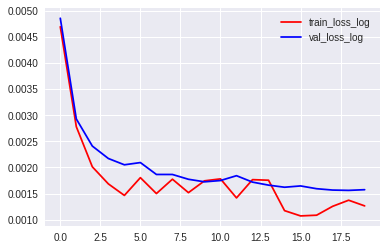

In [57]:
train_net(net, train_loader, test_loader, device='cuda:0')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


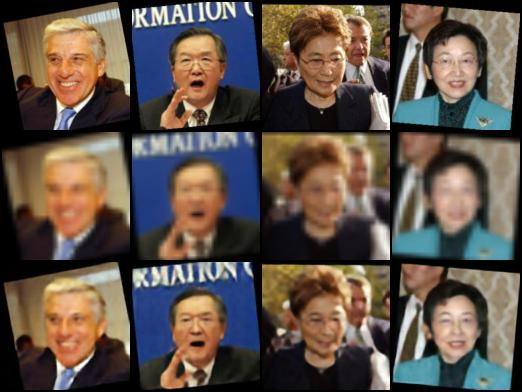

In [58]:
from torchvision.utils import save_image

random_test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
it = iter(random_test_loader)
x, y = next(it)

blin = F.upsample(x, 128, mode='bilinear', align_corners=True)
sr = net(x.to('cuda:0')).to('cpu')

save_image(torch.cat([y, blin, sr], 0), 'cnn_upscale.jpg', nrow=4)

from IPython.display import Image, display_jpeg
display_jpeg(Image('cnn_upscale.jpg'))